## Secrets in bilibili video covers:
    Work on the videos in the bilibili hot list to take insights into the connection between the thumbnail image styles and the genres of these videos!

### Work Flow:
Pictures ->(1) Feature Vectors ->(2) Dis/Similarity Matrix ->(3) Graph ->(4) Community ->(5) Visualization ->(6) Analysis

In [1]:
import feature
import palsgraph
import networkx as nx
# import area for every member to add their source code

In [2]:
# parameters
categories = ['animal','animation','dance','fashion','food','game','kichiku','knowledge','life','music','tech']
num_train_per_cat = 5
num_pictures = len(categories)*num_train_per_cat
data_path = './bilibili_img/'

#### (1）Siamese/CNN network
Input: pictures or their paths. Output: uncertain (Feature Vectors possibly).

In [3]:
# load data
image_paths,labels,genres = feature.get_image_paths(data_path, categories, num_train_per_cat)

# get feature vectors using different methods
features = feature.get_feature_hog(image_paths)   # using hog to extract 


#### (2) Covariance/ Euclidean Distance/Gaussian to get Dis/Similarity Matrix
Input: featurer vectors.Output: dis/simlarity matrix.

if step(1) has directly got the output, then jump to the next step.

In [4]:
# using Euclidean distance to calculate distance/similarity
distance = feature.get_distance(features,num_pictures) 

#### (3) Threshold or some other ways
Input: dis/similarity matrix.
Output: different ways to describe a graph.

some code in Kal's homework may help to find the appropriate threshold.(show the histogram of the data,and then test)

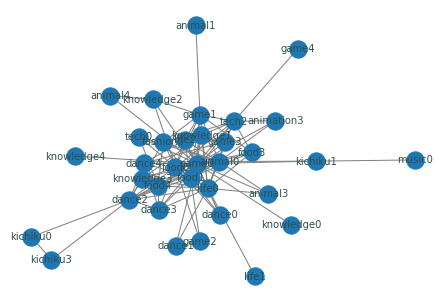

In [5]:
# homework code to visualize similarity matrix in histogram
#plt.figure(figsize=(15, 4))
#_ = plt.hist(squareform(distance), bins=200)

threshold = 19.2   # waiting to be tested
adjmat = feature.get_graph(distance,threshold)
feature.write_edgestxt(num_pictures,adjmat)   # write edges information into a txt file
# help to visualize graph for a simple look
G = palsgraph.make_graph(adjmat, labels=labels, show_singletons=False)
nx.draw(G, with_labels=True,font_size=10,font_color='darkslategray',edge_color='gray')


#### (4) Different Community Detection Algorithms
Input: graph. Output: community in a graph

#### (5) Visualization
Input: community above. Output: different visualizations

#### (6) Analysis 
(I am not sure about whether this part needs any code or something else to help)